# **2022 Spring AI501 Homework assignment 4**
Read the following problem sheet and submit your completed $\texttt{ipynb}$ file.

In [1]:
# EM 알고리즘 이해하는데 본 사이트
# https://www.youtube.com/watch?v=NNwkDi-2xVQ
# https://modern-manual.tistory.com/46

# 코드의 많은 출처가 된 사이트
# https://towardsdatascience.com/group-similar-image-by-using-the-gaussian-mixture-model-em-algorithm-438e9744660c
# https://dhpark1212.tistory.com/entry/%EB%8B%A4%EB%B3%80%EB%9F%89-%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%EB%B6%84%ED%8F%ACMultivariate-Gaussian-Distribution


In [2]:
import numpy as np
import numpy.random as npr
from matplotlib import pyplot as plt
from scipy.special import logsumexp

In this homework, we will implement the EM algorithm for Mixture of Gaussians (MoG) using a toy 2D dataset. The following code loads and plots the target dataset.

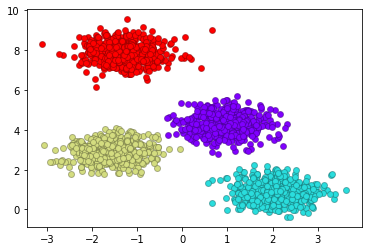

In [3]:
from sklearn.datasets._samples_generator import make_blobs
from matplotlib import cm
x, y_true = make_blobs(n_samples=2000, centers=4, cluster_std=0.50, random_state=0)
def plot_clustering(x, y):
    uy = np.unique(y)    
    colors = cm.rainbow(np.linspace(0, 1, len(uy)))
    for l, c in zip(uy, colors):
        plt.scatter(x[y==l, 0], x[y==l,1], color=c, edgecolor=0.5*c)
plot_clustering(x, y_true)


We assume that the dataset has been generated from a 2D MoG with $k$ components:
$$
p(x;\theta) = \sum_{j=1}^k \pi_j \mathcal{N}(x; \mu_j, \Sigma_j),
$$
where
$$
\theta = \{\pi \in [0,1]^k, \{\mu_j \in \mathbb{R}^d, \Sigma_j\in \mathbb{R}^{d\times d}\}_{j=1}^k\},
$$
and $d=2$. The generative process for a dataset $X =\{x_i\}_{i=1}^n$ with latent variables $Z = \{z_i\}_{i=1}^n$ is given as
$$
z_1,\dots, z_n ; \pi \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Cat}(\pi), \quad 
x_i | z_i; \theta \sim \mathcal{N}(\mu_{z_i}, \Sigma_{z_i}) \text{ for } i=1,\dots,n.
$$

## Problem 1 (20pts)
Implement the E step. That is, complete the following code computing the conditional posterior distribution $p(z_i|x_i;\theta)$. You may use the functions in $\texttt{np.linalg}$ if needed.

In [4]:
# compute p(z|x, theta) and the complete-data log-likelihood.
# inputs
# x: n * d dim matrix where n is the number of data points and d is the dimension
# pi: k dim vector where k is the number of components
# mu: k * d dim matrix where the kth row corresponds to the mean of kth component
# Sigma: k * d * d dim tensor where kth matrix corresponds to the covariance of the kth component
# outputs
# res: n * k matrix computing responsibility matrix (res_ij = p(z_i=j|x_i, theta))
"""
즉, x는 데이터(n * d matrix)
pi는 class를 나타내는 k dim vector (k가 class 개수. MoG;Mixture of Gaussian의 갯수니까)
mu는 각 class별 mean (k개의 class * d matrix)
Sigma kth component의 covariance는 kth matrix (k * d * d)
"""
def Estep(x, pi, mu, Sigma):
    ############################### fill this part ###############################
    def pdf_multivariate_normal(x_m, covariance, size):           # pdf_multivariate_gauss
        return (1. / (np.sqrt((2 * np.pi)**(size) * np.linalg.det(covariance))) *
              np.exp(-(x_m.T.dot(np.linalg.inv(covariance)).dot(x_m)) / 2))
    
    n = x.shape[0]
    k = mu.shape[0]
    d = mu.shape[1]
    res = np.zeros( (n, k) )  # (n * k)의 0들. 행별로 1번원소부터 k번원소까지 합하면 1이 됨. 각 class별 확률
    
    for i in range(n):
        for j in range(k):
            x_m = x[i] - mu[j]
            covariance = Sigma[j]
            res[i, j] = pi[j] * pdf_multivariate_normal(x_m, covariance, d)
            
    # Add up responsibilities over each data point and normalize
    row_sums = res.sum(axis = 1) [:, np.newaxis]
    res = res / row_sums    # The shape of res is preserved.
    ##############################################################################
    return res

In [5]:
# # 출처
# # https://github.com/rasbt/python_reference/blob/master/useful_scripts/multivariate_gaussian_pdf.py
# # https://dhpark1212.tistory.com/entry/%EB%8B%A4%EB%B3%80%EB%9F%89-%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88-%EB%B6%84%ED%8F%ACMultivariate-Gaussian-Distribution

## Problem 2 (50pts)
Implement the M step. Complete the following code computing the updated parameters $\theta$ maximizing the complete-data log-likelihood.



In [6]:
# inputs
# x: n * d dim matrix where n is the number of data points and d is the dimension
# res: n * k matrix computing responsibility matrix (res_ij = p(z_i=j|x_i, theta))
# outputs
# pi: k dim vector where k is the number of components
# mu: k * d dim matrix where the kth row corresponds to the mean of kth component
# Sigma: k * d * d dim tensor where kth matrix corresponds to the covariance of the kth component
def Mstep(x, res):   

    ############################### fill this part ############################### 
    # calculate the cluster weight and yield the updated one
    # sum over the soft counts of all clusters
    soft_count = np.sum(res, axis = 0)

    # basic variables
    n = x.shape[0]
    d = x.shape[1]
    k = len(soft_count)

    # update pi (weights)
    sum_count = np.sum(soft_count)
    pi = np.array(list(map(lambda i : soft_count[i] / sum_count, range(k))))

    # get the new mu (means)
    mu = np.zeros((k, d))
    for i in range(k):
        weighted_sum = 0
        for j in range(n):
            weighted_sum = weighted_sum + res[j, i] * x[j]
        mu[i] = weighted_sum / soft_count[i]
    
    # get Sigma (covariances)
    Sigma = np.zeros( (k, d, d) )

    for i in range(k):
        w_s = np.zeros((d, d))
        for j in range(n):
            w_s = w_s + res[j, i] * np.outer((x[j] - mu[i]), (x[j] - mu[i]).T)
        Sigma[i] = w_s / soft_count[i]  # normalize by total sum of counts


    ##############################################################################
    
    # to prevent underflow
    Sigma = Sigma + 0.01*np.eye(x.shape[1])[None]
    
    return pi, mu, Sigma
    


## Problem 3 (10pts)
We will check the convergence by monitoring the log-likelihood values. Complete the following code computing the log-likelihood 
$$
\log p(X;\theta) = \sum_{i=1}^n \log p(x_i;\theta)
$$.



In [7]:
# inputs
# x: n * d dim matrix where n is the number of data points and d is the dimension
# pi: k dim vector where k is the number of components
# mu: k * d dim matrix where the kth row corresponds to the mean of kth component
# Sigma: k * d * d dim tensor where kth matrix corresponds to the covariance of the kth component
# outputs
# ll: a scalar computing the log-likelihood
def log_likelihood(x, pi, mu, Sigma):    
    ############################### fill this part ############################### 
    # basic variables
    n = x.shape[0]
    d = x.shape[1]
    k = mu.shape[0]
    ll = 0

    for element in x:
        z = np.zeros(k)
        for i in range(k):
            # compute exponential term in multivariate_normal
            delta = np.array(element) - mu[i]

            inv = np.linalg.inv(Sigma[i])
            exp = np.dot(delta.T, np.dot(inv, delta))

            # compute log-likelihood contribution for this data point and this cluster
            z[i] = z[i] + np.log(pi[i])
            det = np.linalg.det(Sigma[i])

            z[i] = z[i] - 1/2 * (d * np.log(2 * np.pi) + np.log(det) + exp)

            # Increment log-likelihood contribution of this data point across all clusters
        ll = ll + np.log(np.sum(np.exp(z)))

    ##############################################################################
    return ll

The code of the EM algorithm for MoGs is given below. Run the code and check the results.

step 47 converged, log-likelihood -5592.4853


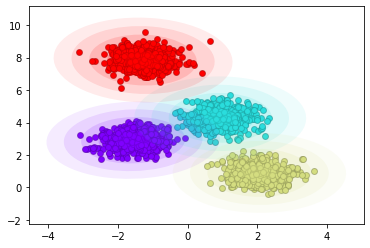

In [8]:
def run_em(x, k, num_steps):
    res = npr.rand(x.shape[0], k)
    res = res / res.sum(-1, keepdims=True)
    pi, mu, Sigma = Mstep(x, res)

    prev_ll = 0
    for t in range(1, num_steps+1):
        res = Estep(x, pi, mu, Sigma)
        pi, mu, Sigma = Mstep(x, res)

        ll = log_likelihood(x, pi, mu, Sigma)

        if t > 1 and abs((ll - prev_ll)/prev_ll) < 1e-7:
            print(f'step {t} converged, log-likelihood {ll:.4f}')
            break
        else:
            prev_ll = ll

        if t % 100 == 0:
            print(f'step {t}, log-likelihood {ll:.4f}')        
           
    return res, pi, mu, Sigma

from matplotlib.patches import Ellipse

def plot_mog(x, res, mu, Sigma, ax=plt.gca()):
    y = res.argmax(-1)
    uy = np.unique(y)    
    colors = cm.rainbow(np.linspace(0, 1, len(uy)))
    for l, c in zip(uy, colors):
        ax.scatter(x[y==l, 0], x[y==l,1], color=c, edgecolor=0.5*c)
        U, s, V = np.linalg.svd(Sigma[l])
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2*np.sqrt(s)
        for nsig in range(1, 6):
            ax.add_patch(Ellipse(mu[l], nsig*width, nsig*height, angle,
                                 alpha=0.4/nsig, fc=c))

res, pi, mu, Sigma = run_em(x, 4, 500)
plot_mog(x, res, mu, Sigma)

## Problem 4 (20pts)
One can compare the different choices of the number of mixture components $k$ using information criterions. One of such is Bayesian Information Criterion (BIC) which is defined as follows.
$$
\mathrm{BIC}(X,\theta) = M \log n - 2 \log p(X;\hat{\theta}),
$$
where $M$ is the number of free parameters, $n$ is the number of data points in $X$, $\hat\theta$ is the maximum-likelihood estimator, and a lower BIC means a better model.Complete following code computing BIC for MoGs and comparing different choices of $k$s based on it. Be cautious when computing the number of free parameters; for instance, $\pi$ has only $(k-1)$ free parameters (think about the reason).


Running EM with k=2...
step 21 converged, log-likelihood -6850.2198

Running EM with k=3...
step 46 converged, log-likelihood -6319.9787

Running EM with k=4...
step 46 converged, log-likelihood -5592.4853

Running EM with k=5...
step 71 converged, log-likelihood -5587.3407

Running EM with k=6...
step 94 converged, log-likelihood -5590.8616

Running EM with k=7...
step 100, log-likelihood -5580.0803
step 118 converged, log-likelihood -5579.8786


Text(0, 0.5, 'BIC')

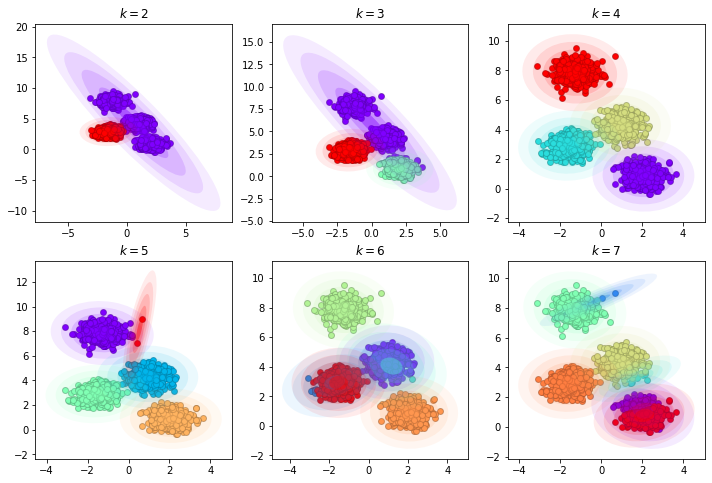

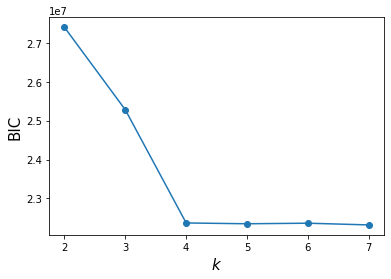

In [9]:
# inputs
# x: n * d dim matrix where n is the number of data points and d is the dimension
# pi: k dim vector where k is the number of components
# mu: k * d dim matrix where the kth row corresponds to the mean of kth component
# Sigma: k * d * d dim tensor where kth matrix corresponds to the covariance of the kth component
# outputs
# bic: a scalar computing the log-likelihood
def BIC(x, pi, mu, Sigma):
    ############################### fill this part ############################### 
    n = x.shape[0]
    k = mu.shape[0]     # n_component
    d = mu.shape[1]     # n_features
    free_p = ( k * d * (d + 1) / 2.0 ) + ( d * k ) + k - 1    # the covariance type is full:  https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
    # https://github.com/scikit-learn/scikit-learn/blob/80598905e517759b4696c74ecc35c6e2eb508cff/sklearn/mixture/_gaussian_mixture.py#L719

    # score 구하는 방법을 알 것. logp(X;theta)
    score = log_likelihood(x, pi, mu, Sigma)

    bic = -2 * score * n + free_p * np.log(n)
    ##############################################################################
    return bic

bics = []
num_steps = 500
ks = np.arange(2, 8)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for k, ax in zip(ks, axes.flatten()):
    print(f'\nRunning EM with k={k}...')
    ax.set_title(rf'$k={k}$')
    res, pi, mu, Sigma = run_em(x, k, num_steps)
    plot_mog(x, res, mu, Sigma, ax=ax)
    bics.append(BIC(x, pi, mu, Sigma))

plt.figure(figsize=(6,4))
plt.plot(ks, bics, 'o-')
plt.xlabel(r'$k$', fontsize=15)
plt.ylabel('BIC', fontsize=15)